# Reti neurali: riconoscimento cifre scritte a mano

![mnist](mnist.jpg)


## Introduzione 

***

Nel contesto dell'analisi dei dati e dell'intelligenza artificiale, il riconoscimento di caratteri scritti a mano è stato (ed è tuttora) un problema affascinante e rilevante. L'obiettivo di questo progetto è sviluppare e addestrare una rete neurale in grado di riconoscere le cifre scritte a mano, sfruttando il famoso dataset MNIST (Modified National Institute of Standards and Technology). MNIST è un insieme di immagini in scala di grigi rappresentanti cifre da 0 a 9 di dimensioni 28x28 pixel, ognuna acquisita da scritture manuali diverse.

Nel corso di questo progetto, utilizzerò la libreria Keras e applicherò tecniche di deep learning per costruire e addestrare una rete neurale per affrontare questa sfida. Le reti neurali sono particolarmente adatte per questo tipo di compito poiché sono in grado di catturare e apprendere gerarchie di caratteristiche dalle immagini in modo efficiente.

Nell'ultima parte del progetto, testerò il modello su 10 immagini di numeri scritti a mano da me.

Fonte dati di addestramento: [http://yann.lecun.com/exdb/mnist/]()

***

Importazione moduli

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import os

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import History
from keras.regularizers import l2

from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray

## Importazione e preprocessing dei dati

***

In questa sezione verrà caricato il dataset ed eseguite le operazioni necessarie a trasformare i dati nel formato ottimale per l'addestramento. Nello specifico:

- Divisione del dataset in sezione di addestramento e sezione di test
- Reshaping delle features
- Normalizzazione delle features
- One-Hot encoding del target

***

Caricamento del dataset

In [41]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

display(X_train.shape)
display(X_test.shape)

(60000, 28, 28)

(10000, 28, 28)

Reshaping delle features di addestramento e di test e normalizzazione

In [42]:
max_value = max(X_train.flatten())

X_train = X_train.reshape(60000, 28*28) / max_value
X_test = X_test.reshape(10000, 28*28) / max_value

display(X_train.shape)
display(X_test.shape)

(60000, 784)

(10000, 784)

Visualizzazione di un esempio contenuto nel dataset

3

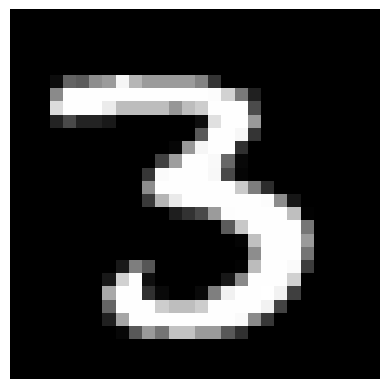

In [43]:
plt.imshow(X_train[12].reshape([28, 28]), cmap='gray')
plt.axis('off')
display(y_train[12])

One-hot encoding delle classi di target

In [44]:
# Trova il numero delle classi di target
num_classes = len(set(y_train))

y_train_dummy = to_categorical(y_train, num_classes)
y_test_dummy = to_categorical(y_test, num_classes)

print("Numero classi:", num_classes)
display(y_train_dummy.shape)
display(y_test_dummy.shape)

# Crea un dataframe con le codifiche
dummies = pd.DataFrame(np.column_stack([y_train, y_train_dummy]), columns=["number", 
                                                                "0", "1", "2", "3", "4", 
                                                                 "5", "6", "7", "8", "9"]).drop_duplicates().set_index("number")
dummies.sort_index(inplace=True)

dummies

Numero classi: 10


(60000, 10)

(10000, 10)

,0,1,2,3,4,5,6,7,8,9
number,,,,,,,,,,
0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Creazione della rete neurale
***

In questa sezione verrà creata l'architettura della rete neurale. Si tratta di una rete con 3 strati nascosti, rispettivamente di 512, 256 e 128 nodi. Ognuno dei 3 strati utilizzerà la ReLu come funzione di attivazione mentre lo strato di output, trattandosi di un problema di classificazione multipla, utilizzerà la funzione SoftMax.

per ridurre il rischio di overfitting, verranno aggiunti 3 strati di dropout che interesseranno il 50% dei nodi e una regolarizzazione l2 il cui parametro $\lambda$ si riduce di 1/10 a ogni strato.

***

Creazione dell'architettura della rete neurale

In [45]:
model = Sequential()

model.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu',  kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Visualizza l'architettura della rete neurale
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               401920    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 10)               

## Addestramento del modello

***

In questa sezione il modello verrà compilato e addestrato. Come ottimizzatore verrà usato l'adam, viste le sue ottime performance. La funzione di costo, trattandosi di un problema di classificazione multipla, sarà la categorical_cross

N.B. per ottimizzare le prestazioni il modello esegue il gradient descent utilizzando un determinato numero di esempi di training per volta (mini-batch gradient descent), la cui dimensione è stata impostata a $2^9 = 512$. Il numero di epoche sarà impostato a 80 e il set di validazione verrà ricavato dal 20% del set di addestramento.

Verrà infine calcolato il tempo di addestramento, estratte le metriche dell'ultima epoca e visualizzato un grafico che mostri l'andamento di funzione di costo e accuracy per epoca e dataset.

***

Compilazione del modello e addestramento


L'addestramento si è concluso in 0 minuti e 50 secondi

Numero epoche: 80

Metriche all'ultima epoca:
loss 0.641
accuracy 0.901
val_loss 0.482
val_accuracy 0.947


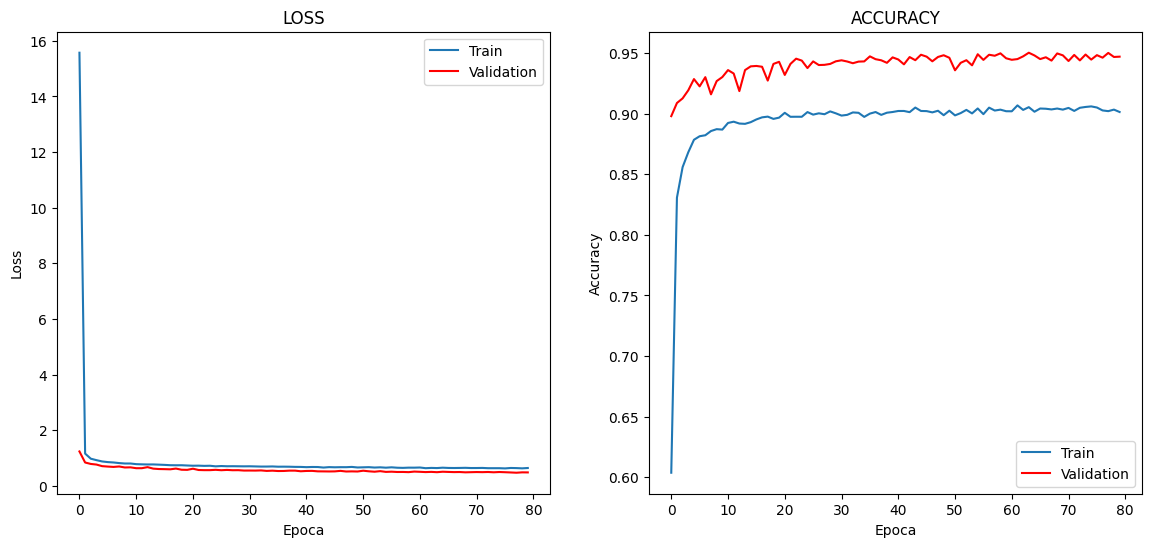

In [46]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = History()
n_epochs = 80


# Registra il momento di inizio dell'addestramento
start_time = time()

model.fit(X_train, y_train_dummy, epochs=n_epochs, batch_size=512, validation_split=0.2, verbose=False, callbacks=[history])

# Calcola la durata dell'addestramento
end_time = time() - start_time

print("\nL'addestramento si è concluso in %d minuti e %d secondi" % (end_time/60, end_time%60))

print("\nNumero epoche: %d" % (n_epochs))

# Estrae le metriche di loss e accuracy dell'ultima epoca
print("\nMetriche all'ultima epoca:")
for x in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    print(x, round(history.history[x][-1], 3))

# Rappresenta i valori di loss e accuracy su un grafico
fig, ax = plt.subplots(1, 2, figsize=[14, 6]) 

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'], color="red")
ax[0].set_xlabel('Epoca')
ax[0].set_ylabel('Loss')
ax[0].legend(["Train", "Validation"])
ax[0].set_title("LOSS")

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'], color="red")
ax[1].set_xlabel('Epoca')
ax[1].set_ylabel('Accuracy')
ax[1].legend(["Train", "Validation"])
ax[1].set_title("ACCURACY");

## Valutazione del modello

***

In questa sezione il modello verrà valutato sui dati di test. Successivamente, verrà estratto un campione casuale di 5 elementi dal set di test su cui verrà testato il riconoscimento ed estratti gli eventuali errori.

Verifica del modello sul test set

In [47]:
model.evaluate(X_test, y_test_dummy)

313/313 [==============================] - 0s 1ms/step - loss: 0.4955 - accuracy: 0.9407


[0.4954834580421448, 0.9406999945640564]

Estrazione di un campione di 5 elementi dal test set 

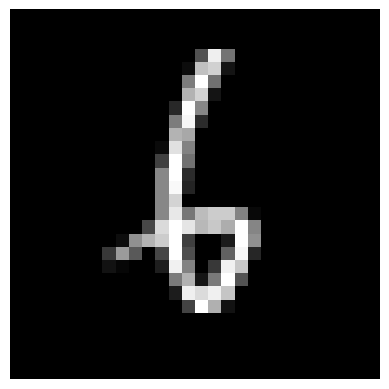

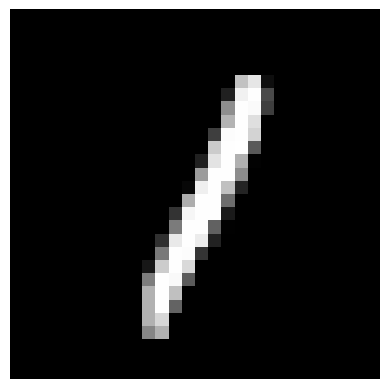

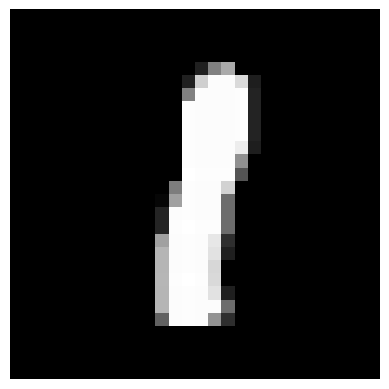

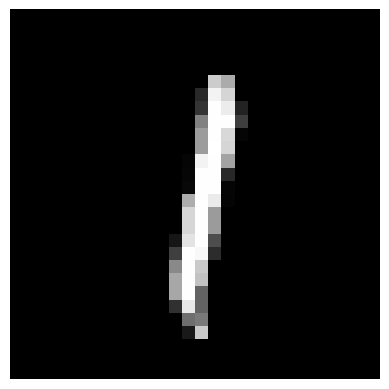

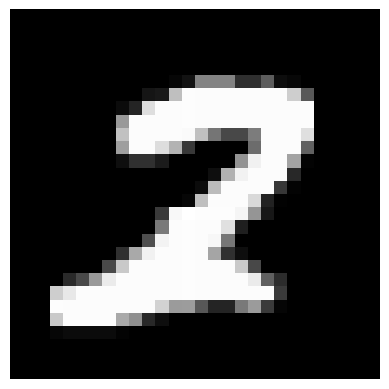

In [48]:
# Il seed consente di ottenere gli stessi risultati per le operazioni casuali
np.random.seed(0)

test_images = []
targets = []

# Estrae un campione casuale di 5 immagini dal set di test
for n in np.random.randint(0, X_test.shape[0], size=5):
    
    image = X_test[n]
    target = y_test[n]
    
    test_images.append(image)
    targets.append(target)
    
    plt.imshow(image.reshape([28,28]), cmap='gray')
    plt.axis('off')
    plt.show()

# Converte le liste in array
test_images = np.array(test_images)
targets = np.array(targets)

In [49]:
# Funzione per ottenere la % di errore e i singoli errori delle predizioni
def get_incorrects(targets, y_pred, test_images):
    
    mask = (y_pred == targets) == False
    
    print('\n% errore:', sum(mask) / len(test_images))
    
    if sum(mask) > 0:
    
        print("Predetti:", y_pred[mask])
        print("Target:", targets[mask])

        for image in test_images[mask]:
            plt.imshow(image.reshape([28,28]), cmap='gray')
            plt.axis('off')
            plt.show()
    else:
        print("\nNessun errore.")

Predizioni sul campione e verifica degli eventuali errori

In [50]:
# Predizioni
y_pred = np.array([model.predict(image.reshape(1, -1), verbose=False).argmax() for image in test_images])

# Errori
get_incorrects(targets, y_pred, test_images)


% errore: 0.0

Nessun errore.


## Test del modello con immagini proprie

***

In questa sezione verranno caricate le immagini di 10 cifre scritte a mano da me, su cui verrà effettuato il riconoscimento attraverso il modello. 

Di seguito un'immagine delle cifre:

![numbers](numbers.png)

***

Importazione delle immagini

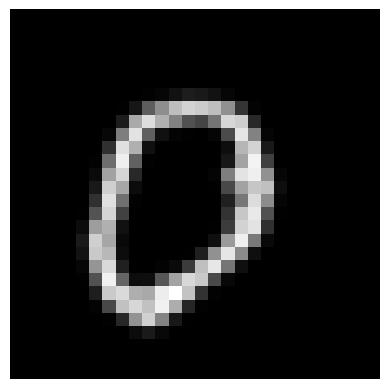

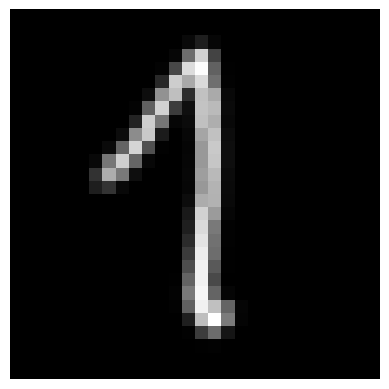

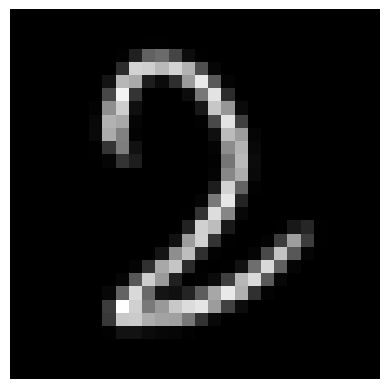

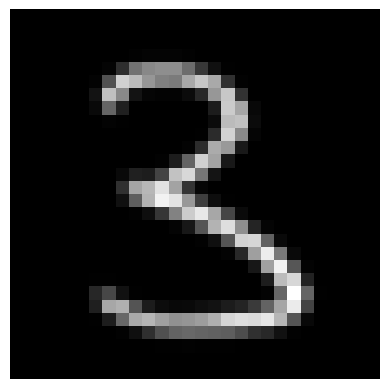

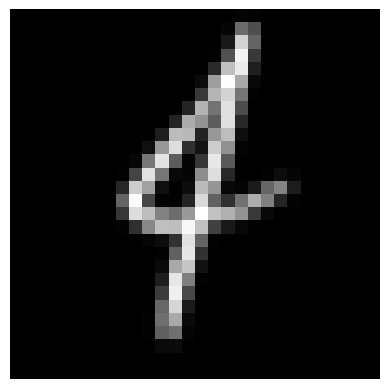

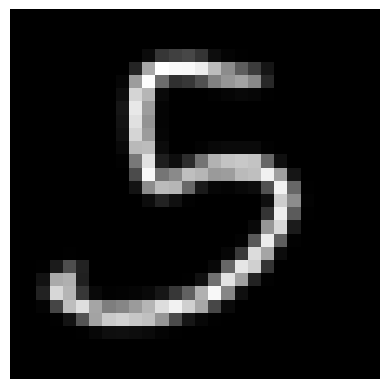

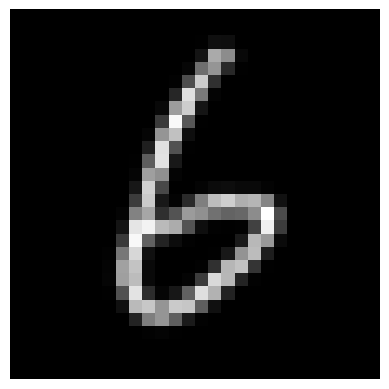

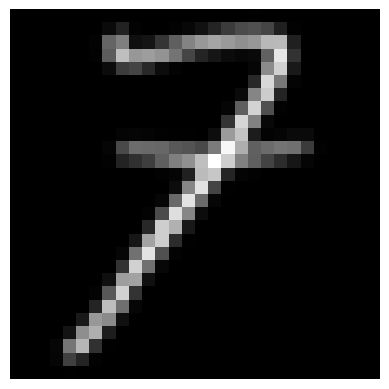

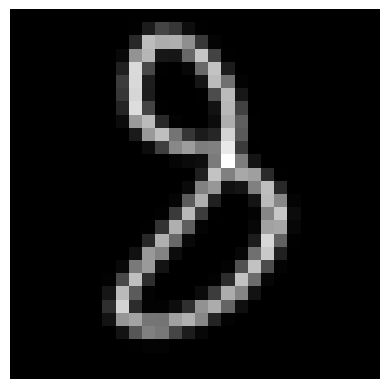

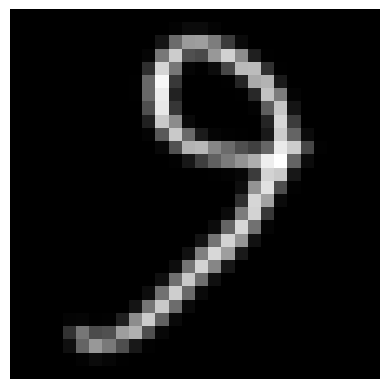

In [51]:
# Directory contenente le immagini
directory = os.getcwd() + '/handwritten_numbers'

my_images = []

for file in sorted(os.listdir(directory)):

    image = io.imread(directory + '/' + file)
    
    # Inverte i colori di numero e sfondo da nero su sfondo bianco a bianco su sfondo nero
    image_resized = 1 - rgb2gray(resize(image, [28,28]))

    image_resized = image_resized.reshape([1, 28*28])
    
    my_images.append(image_resized)
    
    plt.imshow(image_resized.reshape([28, 28]), cmap='gray')
    plt.axis('off')
    plt.show()

# Converte la lista in array
my_images = np.array(my_images)

Predizioni sulle immagini importate


% errore: 0.3
Predetti: [1 3 7]
Target: [7 8 9]


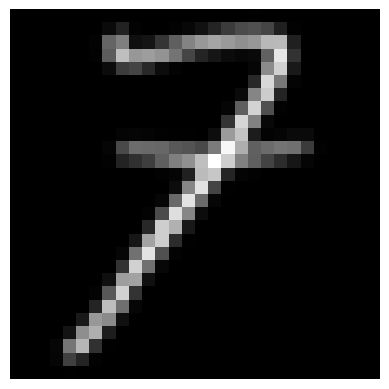

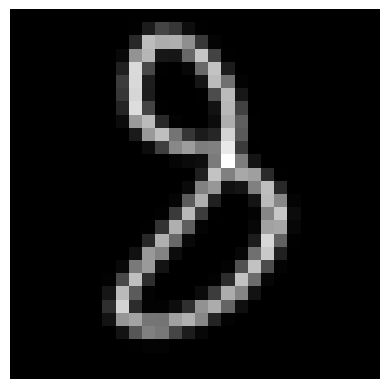

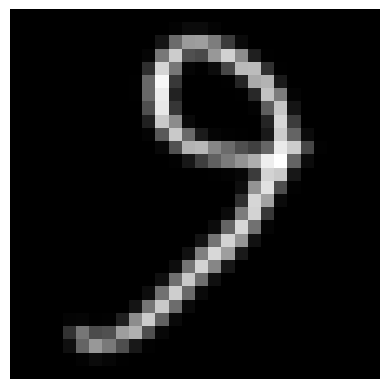

In [52]:
my_targets =np.arange(10)

my_preds = np.array([model.predict(image, verbose=False).argmax() for image in my_images])

get_incorrects(my_targets, my_preds, my_images)

## Conclusioni

***
Il modello si comporta in maniera eccellente con i dati di test che fanno parte del dataset MNIST, ma ha qualche difficoltà nel riconoscere le cifre scritte da me, sebbene il risultato sia comunque soddisfacente. Ciò può dipendere (oltre che dalla mia pessima grafia) dal fatto che nessuna cifra all'interno dei dati di addestramento somigliasse sufficientemente a quelle scritte da me (effettivamente, il mio 9 può essere scambiato facilmente per un 7).

Inoltre, la rete neurale creata è del tipo "completamente connessa", dal momento che ogni strato è denso. Con ogni probabilità, una rete neurale di tipo convoluzionale si comporterebbe in maniera ancora più performante e riuscirebbe a classificare correttamente anche le cifre scritte a mano da me. In un progetto futuro, proverò a costruirne una.

***